In [1]:
import time
from multiprocessing import Pool

from IPython.display import display

import sympy
sympy.init_printing()
from sympy.simplify.fu import fu, TR5, TR7, TR2i, TR10i
# help(sys.modules['sympy.simplify.fu'])

from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from itertools import cycle
lstyle = cycle(('-', '--', ':', '-.',\
    (0, (1, 10)), (0, (5, 10)),\
    (0, (5, 5)), (0, (3, 10, 1, 10)),\
    (0, (3, 5, 1, 5)), \
    (0, (3, 5, 1, 5, 1, 5))))
color = cycle(('#1f77b4', '#ff7f0e', '#2ca02c',\
    '#d62728', '#9467bd', '#8c564b', '#e377c2',\
    '#7f7f7f', '#bcbd22', '#17becf'))

from scipy.sparse import *
from scipy.sparse.linalg import spsolve

**Точное решение**

ТРУДЫ МФТИ. 2017. Том 9, № 1 В. П. Ковалёв, Е. Ю. Просвиряков, Г. Б. Сизых

Получение примеров точных решений уравнений Навье–Стокса для винтовых течений методом суммирования скоростей

\begin{equation} \label{eq1}
\left\lbrace 
\begin{array}{l}
 u = e^{-4t/\mathrm{Re}}\left(A\sin(2z) + C \cos(2y)\right),\\
 v = e^{-4t/\mathrm{Re}}\left(B\sin(2x) + A \cos(2z)\right),\\
 w = e^{-4t/\mathrm{Re}}\left(C\sin(2y) + B \cos(2x)\right),\\
 p = -e^{-8t/\mathrm{Re}}\left(
 \left(A\sin(2z) + C \cos(2y)\right)^2 +
 \left(B\sin(2x) + A \cos(2z)\right)^2 +
 \left(C\sin(2y) + B \cos(2x)\right)^2
 \right)/2 . 
\end{array}
\right. 
\end{equation}

In [2]:
t, x, y, z, Re = sympy.symbols('t, x, y, z, Re', real=True)
A, B, C, k = sympy.symbols('A, B, C, k', real=True)
def div(a, b, c):
    return sympy.diff(a, x) + sympy.diff(b, y) + sympy.diff(c, z)
def delta(a):
    return sympy.diff(a, x, 2) + sympy.diff(a, y, 2) + sympy.diff(a, z, 2)

In [3]:
u = sympy.exp(-4*t/Re)*(A*sympy.sin(k*z) + C*sympy.cos(k*y))
v = sympy.exp(-4*t/Re)*(B*sympy.sin(k*x) + A*sympy.cos(k*z))
w = sympy.exp(-4*t/Re)*(C*sympy.sin(k*y) + B*sympy.cos(k*x))
p = -sympy.exp(-8*t/Re)*(
    (A*sympy.sin(k*z) + C*sympy.cos(k*y))**2 +
    (B*sympy.sin(k*x) + A*sympy.cos(k*z))**2 +
    (C*sympy.sin(k*y) + B*sympy.cos(k*x))**2)/2

In [4]:
div(u, v, w).expand()

In [5]:
r = div(u*u.diff(x) + v*u.diff(y) + w*u.diff(z) + p.diff(x),\
    u*v.diff(x) + v*v.diff(y) + w*v.diff(z) + p.diff(y),\
    u*w.diff(x) + v*w.diff(y) + w*w.diff(z) + p.diff(z)).trigsimp()
r.expand()

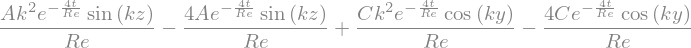

In [6]:
r = (u.diff(t) + div(u**2 + p - u.diff(x)/Re,\
                 v*u - u.diff(y)/Re,\
                 w*u - u.diff(z)/Re)).trigsimp()
r.expand()

In [7]:
r.expand().subs({k: 2})

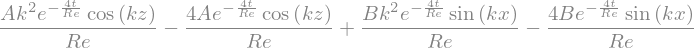

In [8]:
r = (v.diff(t) + div(u*v - v.diff(x)/Re,\
                 v**2 + p - v.diff(y)/Re,\
                 w*v - v.diff(z)/Re)).trigsimp()
r.expand()

In [9]:
r.expand().subs({k: 2})

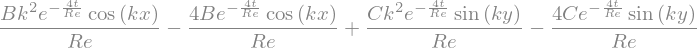

In [10]:
r = (w.diff(t) + div(u*w - sympy.diff(w, x)/Re,\
                 v*w - sympy.diff(w, y)/Re,\
                 w**2 + p - sympy.diff(w, z)/Re)).trigsimp()
r.expand()

In [11]:
r.expand().subs({k: 2})

In [12]:
def MIPT(t, x, y, z, Re, A, B, C):
    U = A*sin(2.*z) + C*cos(2.*y)
    V = B*sin(2.*x) + A*cos(2.*z)
    W = C*sin(2.*y) + B*cos(2.*x)
    e4, e8 = exp(-4.*t/Re), exp(-8.*t/Re)  
    return e4*U, e4*V, e4*W, -e8/2.*(U**2 + V**2 + W**2)

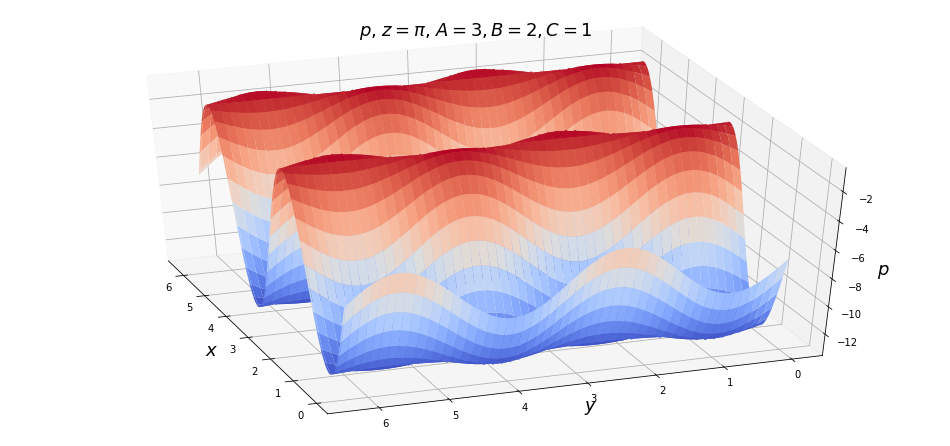

In [13]:
h, Re = 2.5e-2, 1.e2
x, y = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
                arange(0., 2.*pi, h, dtype=float64), indexing='ij')

fig = figure(figsize=(13, 6))
axes = Axes3D(fig)
axes.plot_surface(x, y, MIPT(0., x, y, pi, Re, 3., 2., 1.)[3], \
                  rstride=5, cstride=5, cmap=cm.coolwarm)
axes.set_xlabel(r"$x$", {'fontsize': 18})
axes.set_ylabel(r"$y$", {'fontsize': 18})
axes.set_zlabel(r"$p$", {'fontsize': 18})
axes.set_title(r"$p$, $z=\pi$, $A=3, B=2, C=1$", {'fontsize': 18})
axes.view_init(azim=160., elev=40.)
show()
# savefig('./taylor_decaying_exact_p.pdf')
close()


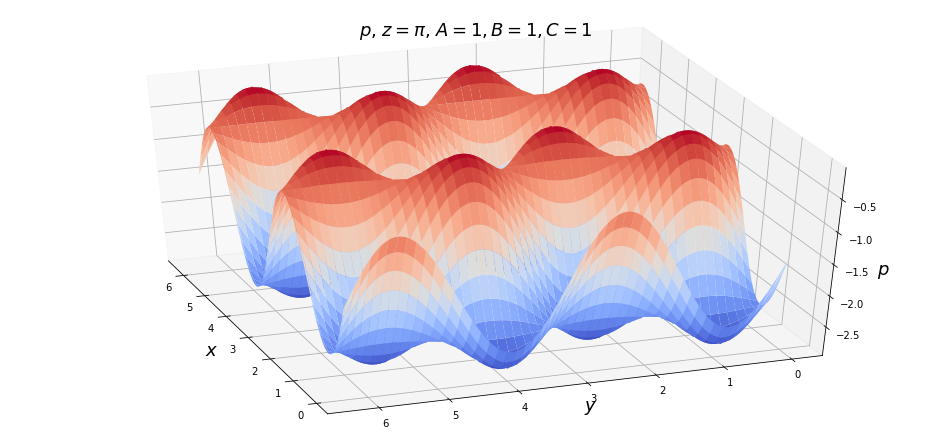

In [14]:
h, Re = 2.5e-2, 1.e2
x, y = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
                arange(0., 2.*pi, h, dtype=float64), indexing='ij')

fig = figure(figsize=(13, 6))
axes = Axes3D(fig)
axes.plot_surface(x, y, MIPT(0., x, y, pi, Re, 1., 1., 1.)[3], \
                  rstride=5, cstride=5, cmap=cm.coolwarm)
axes.set_xlabel(r"$x$", {'fontsize': 18})
axes.set_ylabel(r"$y$", {'fontsize': 18})
axes.set_zlabel(r"$p$", {'fontsize': 18})
axes.set_title(r"$p$, $z=\pi$, $A=1, B=1, C=1$", {'fontsize': 18})
axes.view_init(azim=160., elev=40.)
show()
# savefig('./taylor_decaying_exact_p.pdf')
close()

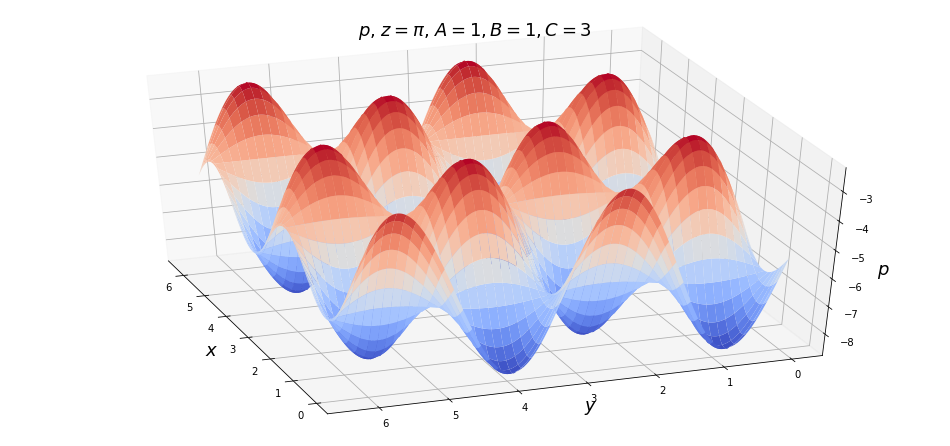

In [15]:
h, Re = 2.5e-2, 1.e2
x, y = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
                arange(0., 2.*pi, h, dtype=float64), indexing='ij')

fig = figure(figsize=(13, 6))
axes = Axes3D(fig)
axes.plot_surface(x, y, MIPT(0., x, y, pi, Re, 1., 1., 3.)[3], \
                  rstride=5, cstride=5, cmap=cm.coolwarm)
axes.set_xlabel(r"$x$", {'fontsize': 18})
axes.set_ylabel(r"$y$", {'fontsize': 18})
axes.set_zlabel(r"$p$", {'fontsize': 18})
axes.set_title(r"$p$, $z=\pi$, $A=1, B=1, C=3$", {'fontsize': 18})
axes.view_init(azim=160., elev=40.)
show()
# savefig('./taylor_decaying_exact_p.pdf')
close()